In [66]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import json
import torch
import cv2

from tqdm import tqdm
from skimage.color import rgb2lab, lab2rgb
from typing import List, Dict, Tuple
from numba import njit
from scipy.ndimage import center_of_mass
from skimage import draw
from skimage.io import imsave, imread

from src.utils import *
from src.refine_transform import *
from src.find_transform import *
from src.shape_align import new_pairwise_alignment

In [2]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [35]:
# load dict from json
# refined_alignment = json.load(open("probs_merged.json", "r"))
refined_alignment = json.load(open("alignments/alignments2.json", "r"))

In [36]:
# parsing frag ids from json
ids = [int(k.split("_")[0]) for k in refined_alignment.keys()]
ids.extend([int(k.split("_")[1]) for k in refined_alignment.keys()])
ids = sorted(list(set(ids)))
print(ids)
frag_numbers = ids
map_id_to_idx = {frag_numbers[i]: i for i in range(len(frag_numbers))}
pad_size = 280
frags = [pad_fragment_to_size(build_fragment_from_directory(data_dir + '/' + str(num)), pad_size) for num in frag_numbers]

[3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 49, 53, 54, 59, 61, 65, 95, 96]


In [37]:
def json_based_to_idx_translation_dict(
    json_based: Dict[str, List],
    id_to_idx: Dict[int, int], 
    frag_numbers: List[int]) -> Dict[Tuple[int, int], List[Translation]]:
    res = {}
    for k, v in tqdm(json_based.items()):
        key = (id_to_idx[int(k.split("_")[0])], id_to_idx[int(k.split("_")[1])])
        res[key] = [Translation(*val.values()) for val in v]
    return res
    

In [38]:
refined_alignment = json_based_to_idx_translation_dict(refined_alignment, map_id_to_idx, frag_numbers)

100%|█████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 129791.17it/s]


In [39]:
from src.reestimating import *
from src.visualize import *

In [40]:
print([(fr_num, i) for i, fr_num in enumerate(frag_numbers)])

[(3, 0), (5, 1), (6, 2), (7, 3), (8, 4), (9, 5), (10, 6), (11, 7), (12, 8), (14, 9), (15, 10), (49, 11), (53, 12), (54, 13), (59, 14), (61, 15), (65, 16), (95, 17), (96, 18)]


In [41]:
def rotate_fragment(frag, angle, c=None):
    """
    fast rotate
    """
    # TODO: rotate edge_coords
    h, w = frag.fragment.shape[:2]
    if c is None:
        c = (w // 2, h // 2)
    m = cv2.getRotationMatrix2D(center=c, angle=angle, scale=1.0)
    fr = Fragment(
        cv2.warpAffine(frag.fragment, M=m, dsize=(w, h)),
        cv2.warpAffine(frag.extended_frag, M=m, dsize=(w, h)),
        cv2.warpAffine(frag.mask * 255.0, M=m, dsize=(w, h)) == 255,
        cv2.warpAffine(frag.extended_mask * 255.0, M=m, dsize=(w, h)) == 255
    )
    if fr.fragment.max() > 1:
        fr.fragment = fr.fragment / 255.0
    if fr.extended_frag.max() > 1:
        fr.extended_frag = fr.extended_frag / 255.0
    return fr

Confidence = 0.7886210116637598, translation = Translation(x=393, y=-105, angle=2.8697340014466555, confidence=0.7886210116637598, geom_score=0.9201272487046138)
Confidence = 0.7177226201744235, translation = Translation(x=393, y=-125, angle=7.8697340014466555, confidence=0.7177226201744235, geom_score=0.8422419557898176)


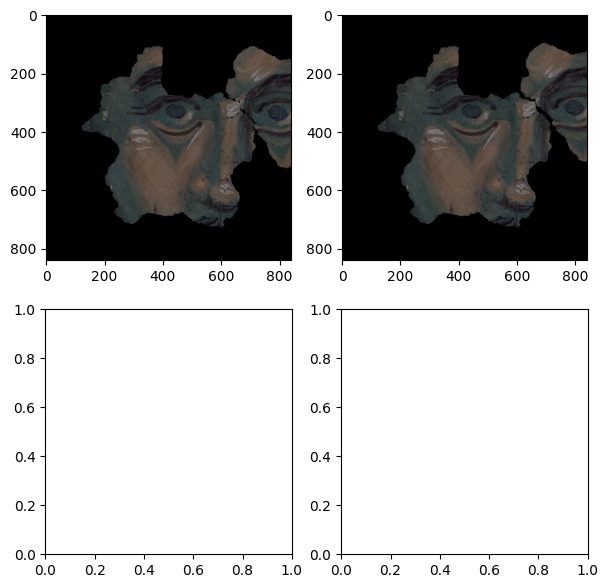

In [42]:
l, r = 5, 15

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
for i in range(len(refined_alignment[(l, r)][:4])):
    tr = refined_alignment[(l, r)][i]
    transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
    blended = blend_fragments(frags[r], transformed)
    
    axes[i // 2][i % 2].imshow(blended.fragment)
#     print(rotate_fragment(pad_fragment_to_size(frags[l], 200), 0).fragment.max())
#     axes[i // 2][i % 2].imshow(pad_fragment_to_size(frags[l], 200).fragment)
    
    print(f"Confidence = {tr.confidence}, translation = {tr}")


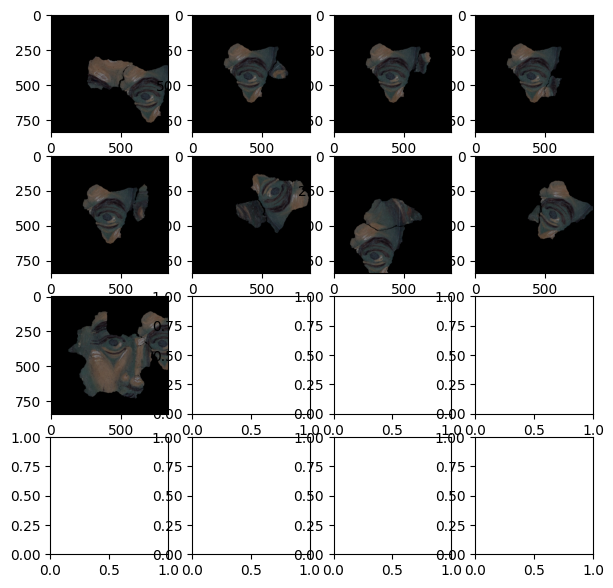

In [44]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(7,7))

l, r, i = 5, 10, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[0][0].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 1, 5, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[0][1].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 2, 5, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[0][2].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 2, 5, 1
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[0][3].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 4, 5, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[1][0].imshow(blend_fragments(frags[r], transformed).fragment)


l, r, i = 5, 6, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[1][1].imshow(blend_fragments(frags[r], transformed).fragment)


l, r, i = 5, 7, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[1][2].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 5, 8, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[1][3].imshow(blend_fragments(frags[r], transformed).fragment)


l, r, i = 5, 15, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
axes[2][0].imshow(blend_fragments(frags[r], transformed).fragment)


840


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


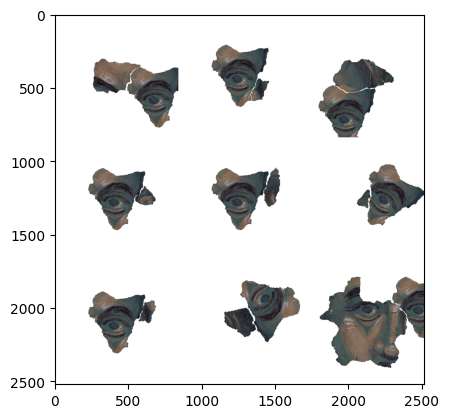

In [81]:
s = transformed.fragment.shape[0]
print(s)
space = 0
vis = np.zeros((s * 3 + space * 4, s * 3 + space * 4, 3))

# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(7,7))

l, r, i = 5, 10, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[space:space + s, space:space + s, :] = new_frag
# vis[space:space + s, space:space + s, :] = transformed.fragment + frags[r].fragment
# axes[0][0].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 1, 5, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[2 * space + s: 2 * space + 2 * s, space:space + s, :] = new_frag
# axes[0][1].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 2, 5, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[3 * space + 2 * s: 3 * space + 3 * s, space:space + s, :] = new_frag
# axes[0][2].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 2, 5, 1
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[space: space + s, 2 * space + s: 2 * space + 2 * s, :] = new_frag
# axes[0][3].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 4, 5, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[2 * space + s: 2 * space + 2 * s, 2 * space + s: 2 * space + 2 * s, :] = new_frag
# axes[1][0].imshow(blend_fragments(frags[r], transformed).fragment)


l, r, i = 5, 6, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[3 * space + 2 * s: 3 * space + 3 * s, 2 * space + s: 2 * space + 2 * s, :] = new_frag
# axes[1][1].imshow(blend_fragments(frags[r], transformed).fragment)


l, r, i = 5, 7, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[space: space + s, 3 * space + 2 * s: 3 * space + 3 * s, :] = new_frag
# axes[1][2].imshow(blend_fragments(frags[r], transformed).fragment)

l, r, i = 5, 8, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[2 * space + s: 2 * space + 2 * s, 3 * space + 2 * s: 3 * space + 3 * s, :] = new_frag
# axes[1][3].imshow(blend_fragments(frags[r], transformed).fragment)


l, r, i = 5, 15, 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
new_frag = transformed.fragment + frags[r].fragment
new_frag /= 1.5
new_frag[np.logical_not(frags[r].mask | transformed.mask)] = 1
vis[3 * space + 2 * s: 3 * space + 3 * s, 3 * space + 2 * s: 3 * space + 3 * s, :] = new_frag
# axes[2][0].imshow(blend_fragments(frags[r], transformed).fragment)
# axes[1][2].imshow(blend_fragments(frags[r], transformed).fragment)

# l, r, i = 5, 8, 0
# tr = refined_alignment[(l, r)][i]
# transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
# axes[1][3].imshow(blend_fragments(frags[r], transformed).fragment)


# l, r, i = 5, 15, 0
# tr = refined_alignment[(l, r)][i]
# transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
# axes[2][0].imshow(blend_fragments(frags[r], transformed).fragment)


plt.imshow(vis)
imsave('../illustrations/pairwise.png', vis)

In [84]:
mask = np.zeros_like(vis)
mask[150:, 150:] = 1
vis_copy = vis[mask]

# vis_copy = vis_copy[700:900, 700:900]
plt.imshow(vis_copy)

IndexError: arrays used as indices must be of integer (or boolean) type